In [ ]:
!pip install folium
!pip install --upgrade folium


  Using cached folium-0.16.0-py2.py3-none-any.whl (100 kB)
  Attempting uninstall: folium
    Found existing installation: folium 0.11.0
    Uninstalling folium-0.11.0:
      Successfully uninstalled folium-0.11.0


In [ ]:
!pip install folium==0.13.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: folium
    Found existing installation: folium 0.14.0
    Uninstalling folium-0.14.0:
      Successfully uninstalled folium-0.14.0


In [ ]:
import folium
print(folium.__version__)

0.13.0


**Introduction**

This report analyzes data on subway ridership and weather patterns in NYC. The question I hope to answer is if there are any correlations between subway ridership and weather conditions, particularly rainfall.

*Data Sources Used*

* Daily Weather Data:
    * Source: National Centers For Environmental Information (NOAA)
    * Variables extracted: Date, Precipitation
* Subway Turnstile Usage Data (2019):
    * Source: MTA Turnstile Usage Data (2019) (Data.gov)
    * Check dates and what the file contains before downloading
    * Use data.gov instead of data.ny.gov -- downloads are quicker
    * Variables extracted: Station, Date, Entries
* Subway Station Information:
    * Source: MTA Subway Stations (Data.gov)
    * Variables extracted: Station Name, Latitude, Longitude


**Methodology**

Data Import and Cleaning:


*   CSV files are imported and converted into Pandas data frames. (do not include table names when downloading CSV files)

*  Data cleaning: renaming columns, converting date formats, and filtering irrelevant data.

Data Analysis (Using Pandas):

* Average precipitation per day is calculated from weather data.
* Daily ridership total entries for BMT (Brooklyn-Manhattan Transit) stations are calculated and aggregated.
* The top 10 most entered stations are calculated.
* Data for these top stations are filtered and merged with station location data based on station name -- (necessary step for using Folium) -- adds latitude and longitude to the stations names within the MTA turnstile usage.
* Data from the stations and locations are merged with weather data based on date.

Visualization:

* Plotly Express created bar charts for specific stations to compare rainy and nonrainy days entries. Hover features were added for readability.
* Time series analysis is performed on ridership data for the merged data sets, rainy days, and nonrainy days using the Dickey-Fuller test to check for stationarity. All of these data sets were used to check the accuracy of the data.
* Folium was used to create a base map of NYC.
* Using GeoJSON, features were created and plotted on the map, representing subway stations with entries and precipitation data over the selected time period.



In [ ]:
import folium
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.express as px


#read csv files
weather = pd.read_csv('daily_weather.csv', usecols=['DATE', 'PRCP'])
ridership = pd.read_csv('Turnstile_Usage_Data__2019.csv', usecols = ['Station','Date','Division','Entries'])
stations = pd.read_csv('MTA_Subway_Stations.csv', usecols =['Stop Name','GTFS Latitude','GTFS Longitude'])
#create dataframes
weather_df = pd.DataFrame(weather)
ridership_df = pd.DataFrame(ridership)
stations_df = pd.DataFrame(stations)
#display(stations_df.head())
#display(ridership_df.head())

#clean data

#clean station df
stations_edited = stations_df.rename(columns ={'Stop Name':'Station'})
stations_edited['Station'] = stations_edited['Station'].str.upper()

#clean weather df
weather_edited = weather_df.rename(columns={'DATE':'Date','PRCP':'Precipitation'})

#clean ridership df
ridership_df = ridership_df.dropna(subset=['Division'])
bmt_ridership_df = ridership_df[ridership_df['Division'].str.contains('BMT')]


#cleaning  weather dates + picking time frame of weather table
weather_edited['Date'] = pd.to_datetime(weather_edited['Date'], format='%Y-%m-%d')
weather_dates = pd.date_range('2018-12-01','2019-02-28')
selected_weather_dates = weather_edited[weather_edited['Date'].isin(weather_dates)]
average_weather_per_day = selected_weather_dates.groupby('Date')['Precipitation'].mean()
#print(average_weather_per_day)
#display(selected_weather_dates.head())

#cleaning ridership dates
bmt_ridership_df['Date'] = pd.to_datetime(bmt_ridership_df['Date'], format='%m/%d/%Y')
rider_dates = pd.date_range('2018-12-01','2019-02-28')
selected_rider_dates = bmt_ridership_df[bmt_ridership_df['Date'].isin(rider_dates)]
average_rider_per_day_per_station = selected_rider_dates.groupby(['Date','Station'])['Entries'].sum().reset_index()
#print(average_rider_per_day_per_station)
#figuring out top 10 stations based on the number of entries
top_10_stations = average_rider_per_day_per_station.groupby('Station').size().nlargest(10)
#print(top_10_stations)
#selecting data for the top 10 stations
data_top_10_stations = average_rider_per_day_per_station[average_rider_per_day_per_station['Station'].isin(top_10_stations.index)]

#merge stations and locations
merged_stations = pd.merge(data_top_10_stations, stations_edited, on='Station', how='inner')
#display(merged_stations.head())

# Merge ridership and weather data
merged_data = pd.merge(average_weather_per_day, merged_stations, on='Date', how='inner')
#print(merged_data)
print(merged_data)

## add column for rain or non rain
merged_data['Rain'] = merged_data['Precipitation'].apply(lambda x: True if x > 0 else False)

##calculate daily ridership
rainy_days = merged_data[merged_data['Precipitation'] > .3]
nonrainy_days = merged_data[merged_data['Precipitation'] < .3]

## create histogram

##histogram cortlandt st
rainy_days_data = rainy_days[rainy_days['Station'] == '1 AV']
nonrainy_days_data = nonrainy_days[nonrainy_days['Station'] == '1 AV']

combined_data = pd.concat([rainy_days_data, nonrainy_days_data])

#make graph
plt.figure(figsize=(15, 10))
fig = px.bar(combined_data, x='Date', y='Entries', color='Rain', color_discrete_map={True: 'blue', False: 'green'})
fig.update_layout(title='Entries per Day for Rainy vs. Non-Rainy Days: 1 AV')
fig.update_layout(xaxis=dict(tickangle=45))
fig.show()


##bar 104 ST
rainy_days_data_104 = rainy_days[rainy_days['Station'] == '104 ST']
nonrainy_days_data_104 = nonrainy_days[nonrainy_days['Station'] == '104 ST']

combined_data2 = pd.concat([rainy_days_data_104, nonrainy_days_data_104])

#make graph
plt.figure(figsize=(15, 10))
fig = px.bar(combined_data2, x='Date', y='Entries', color='Rain', color_discrete_map={True: 'blue', False: 'green'})
fig.update_layout(title='Entries per Day for Rainy vs. Non-Rainy Days: 104 ST')
fig.update_layout(xaxis=dict(tickangle=45))
fig.show()

##bar 121 ST
rainy_days_data_121 = rainy_days[rainy_days['Station'] == '121 ST']
nonrainy_days_data_121 = nonrainy_days[nonrainy_days['Station'] == '121 ST']

combined_data3 = pd.concat([rainy_days_data_121, nonrainy_days_data_121])

#make graph
plt.figure(figsize=(15, 10))
fig = px.bar(combined_data3, x='Date', y='Entries', color='Rain', color_discrete_map={True: 'blue', False: 'green'})
fig.update_layout(title='Entries per Day for Rainy vs. Non-Rainy Days: 121 ST')
fig.update_layout(xaxis=dict(tickangle=45))
fig.show()

##bar union sq
rainy_days_data_sq = rainy_days[rainy_days['Station'] == '14 ST-UNION SQ']
nonrainy_days_data_sq = nonrainy_days[nonrainy_days['Station'] == '14 ST-UNION SQ']

combined_data4 = pd.concat([rainy_days_data_sq, nonrainy_days_data_sq])

#make graph
plt.figure(figsize=(15, 10))
fig = px.bar(combined_data4, x='Date', y='Entries', color='Rain', color_discrete_map={True: 'blue', False: 'green'})
fig.update_layout(title='Entries per Day for Rainy vs. Non-Rainy Days: 14 ST-UNION SQ')
fig.update_layout(xaxis=dict(tickangle=45))
fig.show()



FileNotFoundError: [Errno 2] No such file or directory: 'daily_weather.csv'

**Results**

Rain vs. Non-Rain Analysis:

* Bar charts illustrate the difference in subway entries between rainy and nonrainy days for specific stations.
* Observations suggest slight variations in ridership patterns based on weather conditions. Most selected stations showed slight variation, while others showed a more significant variation.

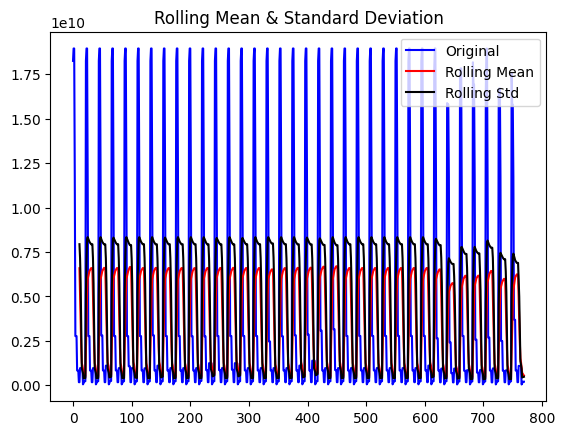

Results of Dickey-Fuller Test:
ADF Statistic                  -24.262912
p-value                          0.000000
#Lags Used                      20.000000
Number of Observations Used    749.000000
Critical Value (1%)             -3.439111
Critical Value (5%)             -2.865407
Critical Value (10%)            -2.568829
dtype: float64


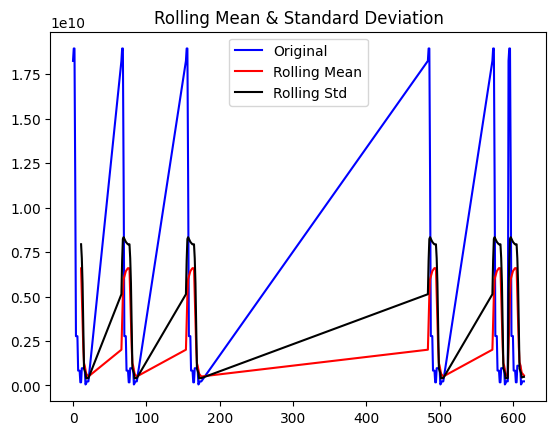

Results of Dickey-Fuller Test:
ADF Statistic                 -5.669841e+00
p-value                        8.974758e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64


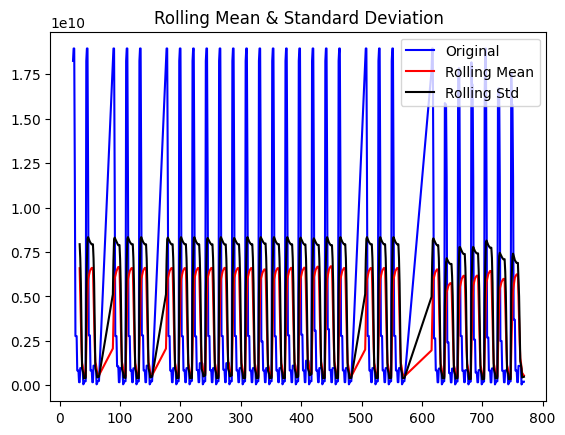

Results of Dickey-Fuller Test:
ADF Statistic                  -20.122898
p-value                          0.000000
#Lags Used                      20.000000
Number of Observations Used    617.000000
Critical Value (1%)             -3.440993
Critical Value (5%)             -2.866236
Critical Value (10%)            -2.569271
dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

In [ ]:
###time series analysis
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determine rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')

    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(merged_data['Entries'].dropna())
test_stationarity(rainy_days['Entries'].dropna())
test_stationarity(nonrainy_days['Entries'].dropna())


plt.show

**Results**

Time Series Analysis:

* The Dickey-Fuller test indicates strong evidence against the null hypothesis of non-stationarity for three separate analyses.
    * First Test (full data set):
        * ADF Statistic: -24.262912
        * p-value: 0.000000
        * Critical Values:
            * 1%: -3.439111
            * 5%: -2.865407
            * 10%: -2.568829
    * Second Test (rainy days dataset):
        * ADF Statistic: -5.669841e+00
        * p-value: 8.974758e-07
        * Critical Values:
            * 1%: -3.487022e+00
            * 5%: -2.886363e+00
            * 10%: -2.580009e+00
    *  Third Test (nonrainy days dataset):
        * ADF Statistic: -20.122898
        * p-value: 0.000000
        * Critical Values:
            * 1%: -3.440993
            * 5%: -2.866236
            * 10%: -2.569271
    * The low p-values (< 0.05) suggest that the time series data is stationary, meaning there was a consistent trend in subway usage over the analyzed period.
    


In [ ]:
import folium

# Create a base map
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=13)

# Create GeoJson features
features = []
for index, row in merged_data.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['GTFS Longitude'], row['GTFS Latitude']]
        },
        'properties': {
            'time': row['Date'].strftime('%Y/%m/%d'),
            'station': row['Station'],
            'entries': row['Entries'],
            'precipitation': row['Precipitation'],
            'popup': f"Station: {row['Station']}<br>Date: {row['Date']}<br>Entries: {row['Entries']}<br>Precipitation: {row['Precipitation']}",
            'icon': "train"
        }
    }
    features.append(feature)
import folium.plugins as plugins
folium.plugins.TimestampedGeoJson(
    {"type": "FeatureCollection", "features": features},
    period="P1D",
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options="YYYY/MM/DD",
    time_slider_drag_update=True,
).add_to(nyc_map)

nyc_map
#nyc_map.save('traffic_density_map.html')



Geo Analysis:

* The Folium map displays the top ten most entered subway stations (duplicates were counted for different locations -- makes the top ten more than 10) overlaid with precipitation data, dates, and entry totals per day, allowing for exploration of ridership patterns. The map allows you to move through the analyzed time period to see data from different dates.

* I would have made the plot points based on size of entry using circles rather than them all being the same size -- makes the map more meaningful (I wasn't sure how to do this using GeoJSON).




**Conclusion**

The analysis provides valuable insights into the correlation between subway ridership and weather conditions. Initially, it was hypothesized that there would be an increase in subway usage during rainier days. The initial thinking behind this was the number of people who may consider walking when it is sunny outside and turn to the subway when it rains. Upon further consideration, this number could be offset by the number of people who decide not to take the subway and call an Uber instead. The Dickey-Fuller tests confirm that the subway ridership is stationary, suggesting no significant impact on subway ridership patterns.

Further investigation could involve looking at a broader range of dates, including different times of the year. Comparing these findings with current post-pandemic ones would also be interesting. The numbers may be altered post-COVID because hybrid working is more accessible, so people may stay home when it rains.
